In [1]:
!pip -q install roboflow pycocotools opencv-python matplotlib tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 89.9 MB/s eta 0:00:00


In [2]:
import torch, torchvision
print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("cuda:", torch.version.cuda)


torch: 2.9.0+cu126
torchvision: 0.24.0+cu126
cuda available: True
cuda: 12.6


In [4]:
from roboflow import Roboflow

rf = Roboflow(api_key="0veS42farWpmazy4gGre")
project = rf.workspace().project("cucumber-leaf-detection")
dataset = project.version(2).download("coco")  # downloads train/valid/test

print("Dataset location:", dataset.location)
print("Classes:", dataset.classes)


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to cucumber-Leaf-detection-2 in coco:: 100%|██████████| 2410/2410 [00:00<00:00, 3324.95it/s]

Dataset location: /content/cucumber-Leaf-detection-2


AttributeError: 'Dataset' object has no attribute 'classes'

In [10]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pycocotools.coco import COCO
import torchvision.transforms.functional as F
import random

class CocoDetectionForFRCNN(Dataset):
    def __init__(self, images_dir, ann_path, transforms=None):
        self.images_dir = images_dir
        self.coco = COCO(ann_path)
        self.img_ids = sorted(self.coco.imgs.keys())
        self.transforms = transforms

        # Map COCO category IDs -> contiguous labels 1..N (0 is background)
        cats = self.coco.loadCats(self.coco.getCatIds())
        self.cat_id_to_contig = {c["id"]: i+1 for i, c in enumerate(sorted(cats, key=lambda x: x["id"]))}
        self.contig_to_name = {v: self.coco.cats[k]["name"] for k, v in self.cat_id_to_contig.items()}

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.images_dir, img_info["file_name"])

        img = Image.open(img_path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []
        areas = []
        iscrowd = []

        for a in anns:
            x, y, w, h = a["bbox"]
            if w <= 1 or h <= 1:
                continue
            boxes.append([x, y, x+w, y+h])
            labels.append(self.cat_id_to_contig[a["category_id"]])
            areas.append(w*h)
            iscrowd.append(a.get("iscrowd", 0))

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        areas = torch.tensor(areas, dtype=torch.float32)
        iscrowd = torch.tensor(iscrowd, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_id]),
            "area": areas,
            "iscrowd": iscrowd
        }

        # transforms
        if self.transforms:
            img, target = self.transforms(img, target)

        # convert PIL -> tensor
        img = F.to_tensor(img)

        return img, target

def train_transforms(img, target):
    # simple augmentation (horizontal flip)
    if random.random() < 0.5:
        img = F.hflip(img)
        w, _ = img.size
        boxes = target["boxes"]
        boxes[:, [0, 2]] = w - boxes[:, [2, 0]]
        target["boxes"] = boxes
    return img, target

def val_transforms(img, target):
    return img, target

def collate_fn(batch):
    return tuple(zip(*batch))

train_dir = os.path.join(dataset.location, "train")
val_dir   = os.path.join(dataset.location, "valid")

train_ann = os.path.join(train_dir, "_annotations.coco.json")
val_ann   = os.path.join(val_dir, "_annotations.coco.json")

train_ds = CocoDetectionForFRCNN(train_dir, train_ann, transforms=train_transforms)
val_ds   = CocoDetectionForFRCNN(val_dir, val_ann, transforms=val_transforms)

BATCH_SIZE = 2  # increase if you have enough GPU RAM
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)

num_classes = len(class_names) + 1  # +1 for background
print("num_classes (with background):", num_classes)



loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
num_classes (with background): 3


In [8]:
import os, json

DATASET_DIR = dataset.location  # /content/My-First-Project-2

train_ann = os.path.join(DATASET_DIR, "train", "_annotations.coco.json")

# If your folder names are different, auto-detect:
if not os.path.exists(train_ann):
    for split in ["train", "training", "Train"]:
        candidate = os.path.join(DATASET_DIR, split, "_annotations.coco.json")
        if os.path.exists(candidate):
            train_ann = candidate
            break

print("Using annotation file:", train_ann)

with open(train_ann, "r") as f:
    coco_json = json.load(f)

class_names = [c["name"] for c in coco_json["categories"]]
class_names = sorted(class_names)

print("Classes:", class_names)
print("Number of classes:", len(class_names))


Using annotation file: /content/cucumber-Leaf-detection-2/train/_annotations.coco.json
Classes: ['Cucumber Leaf', 'objects']
Number of classes: 2


In [11]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Replace the classifier head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)
print("Model ready on:", device)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:01<00:00, 139MB/s]


Model ready on: cuda


In [15]:
from tqdm import tqdm

def train_one_epoch(model, optimizer, loader, device):
    model.train()
    total_loss = 0.0

    for images, targets in tqdm(loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    return total_loss / len(loader)

@torch.no_grad()
def validate_loss(model, loader, device):
    model.train()  # keep train mode to get loss_dict (TorchVision returns losses in train mode)
    total_loss = 0.0

    for images, targets in loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()

    return total_loss / len(loader)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    val_loss = validate_loss(model, val_loader, device)
    lr_scheduler.step()

    print(f"Epoch {epoch+1}/{EPOCHS} | train loss: {train_loss:.4f} | val loss: {val_loss:.4f}")


100%|██████████| 1051/1051 [06:52<00:00,  2.55it/s]


Epoch 1/10 | train loss: 0.1092 | val loss: 0.0895


100%|██████████| 1051/1051 [07:01<00:00,  2.49it/s]


Epoch 2/10 | train loss: 0.0806 | val loss: 0.0599


100%|██████████| 1051/1051 [07:03<00:00,  2.48it/s]


Epoch 3/10 | train loss: 0.0715 | val loss: 0.0465


100%|██████████| 1051/1051 [07:08<00:00,  2.45it/s]


Epoch 4/10 | train loss: 0.0439 | val loss: 0.0482


100%|██████████| 1051/1051 [07:08<00:00,  2.45it/s]


Epoch 5/10 | train loss: 0.0452 | val loss: 0.0482


100%|██████████| 1051/1051 [07:09<00:00,  2.45it/s]


Epoch 6/10 | train loss: 0.0463 | val loss: 0.0550


100%|██████████| 1051/1051 [07:09<00:00,  2.44it/s]


Epoch 7/10 | train loss: 0.0456 | val loss: 0.0550


100%|██████████| 1051/1051 [07:10<00:00,  2.44it/s]


Epoch 8/10 | train loss: 0.0463 | val loss: 0.0555


100%|██████████| 1051/1051 [07:10<00:00,  2.44it/s]


Epoch 9/10 | train loss: 0.0462 | val loss: 0.0558


100%|██████████| 1051/1051 [07:09<00:00,  2.45it/s]


Epoch 10/10 | train loss: 0.0461 | val loss: 0.0561


In [13]:
import os, random, torch
from torch.utils.data import Dataset
from PIL import Image
from pycocotools.coco import COCO
import torchvision.transforms.functional as F

class CocoDetectionForFRCNN(Dataset):
    def __init__(self, images_dir, ann_path, transforms=None, drop_empty=False):
        self.images_dir = images_dir
        self.coco = COCO(ann_path)
        self.img_ids = sorted(self.coco.imgs.keys())
        self.transforms = transforms

        # Optional: remove images that have no annotations
        if drop_empty:
            self.img_ids = [i for i in self.img_ids if len(self.coco.getAnnIds(imgIds=[i])) > 0]

        # Map COCO category ids -> contiguous labels 1..N (0 is background)
        cats = self.coco.loadCats(self.coco.getCatIds())
        cats = sorted(cats, key=lambda x: x["id"])
        self.cat_id_to_contig = {c["id"]: idx + 1 for idx, c in enumerate(cats)}

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.images_dir, img_info["file_name"])
        img = Image.open(img_path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)

        boxes, labels, areas, iscrowd = [], [], [], []

        for a in anns:
            x, y, w, h = a["bbox"]
            # only skip truly invalid boxes
            if w <= 0 or h <= 0:
                continue

            boxes.append([x, y, x + w, y + h])
            labels.append(self.cat_id_to_contig[a["category_id"]])
            areas.append(w * h)
            iscrowd.append(a.get("iscrowd", 0))

        # ✅ IMPORTANT: if empty, force correct shapes
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            areas  = torch.zeros((0,), dtype=torch.float32)
            iscrowd= torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)
            areas = torch.tensor(areas, dtype=torch.float32)
            iscrowd = torch.tensor(iscrowd, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_id]),
            "area": areas,
            "iscrowd": iscrowd
        }

        if self.transforms:
            img, target = self.transforms(img, target)

        img = F.to_tensor(img)
        return img, target

def train_transforms(img, target):
    # ✅ handle empty boxes safely
    if random.random() < 0.5:
        img = F.hflip(img)
        if target["boxes"].numel() > 0:
            w, _ = img.size
            boxes = target["boxes"]
            boxes[:, [0, 2]] = w - boxes[:, [2, 0]]
            target["boxes"] = boxes
    return img, target

def val_transforms(img, target):
    return img, target


In [14]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    return tuple(zip(*batch))

train_dir = os.path.join(dataset.location, "train")
val_dir   = os.path.join(dataset.location, "valid")

train_ann = os.path.join(train_dir, "_annotations.coco.json")
val_ann   = os.path.join(val_dir, "_annotations.coco.json")

# drop_empty=False keeps background images (safe now)
train_ds = CocoDetectionForFRCNN(train_dir, train_ann, transforms=train_transforms, drop_empty=False)
val_ds   = CocoDetectionForFRCNN(val_dir, val_ann, transforms=val_transforms, drop_empty=False)

BATCH_SIZE = 2
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)

print("Train images:", len(train_ds))
print("Val images:", len(val_ds))


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Train images: 2101
Val images: 201


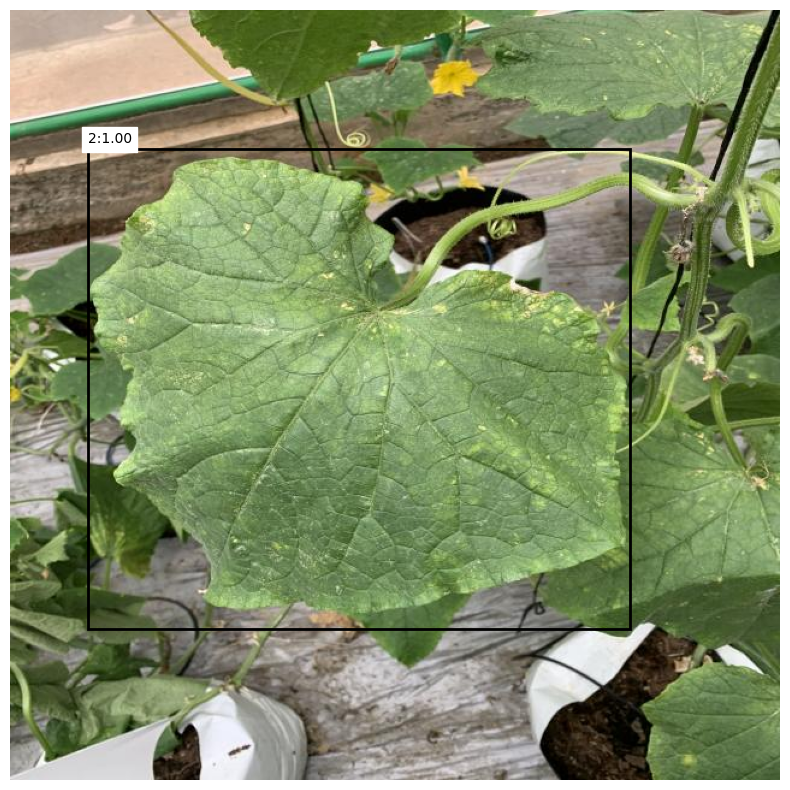

In [17]:
import matplotlib.pyplot as plt
import numpy as np

@torch.no_grad()
def show_predictions(model, dataset_obj, idx=0, score_thr=0.5):
    model.eval()
    img, _ = dataset_obj[idx]
    x = img.to(device)

    preds = model([x])[0]
    keep = preds["scores"] >= score_thr

    boxes = preds["boxes"][keep].cpu().numpy()
    scores = preds["scores"][keep].cpu().numpy()
    labels = preds["labels"][keep].cpu().numpy()

    img_np = (img.permute(1,2,0).numpy() * 255).astype(np.uint8)

    plt.figure(figsize=(10,10))
    plt.imshow(img_np)
    ax = plt.gca()

    for b, s, lab in zip(boxes, scores, labels):
        x1,y1,x2,y2 = b
        ax.add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, linewidth=2))
        ax.text(x1, y1-5, f"{lab}:{s:.2f}", fontsize=10, backgroundcolor="white")

    plt.axis("off")
    plt.show()

show_predictions(model, val_ds, idx=0, score_thr=0.5)


In [19]:
torch.save({
    "model_state": model.state_dict(),
    "num_classes": num_classes,
    "class_names": class_names
}, "fasterrcnn_roboflow.pth")

print("Saved: fasterrcnn_roboflow.pth")


Saved: fasterrcnn_roboflow.pth


### **Test With CV**

Saving 2025_10_23_13_27_IMG_5503.JPG to 2025_10_23_13_27_IMG_5503.JPG
Uploaded image: 2025_10_23_13_27_IMG_5503.JPG
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 181MB/s]


✅ Model loaded
Classes: ['Cucumber Leaf', 'objects']


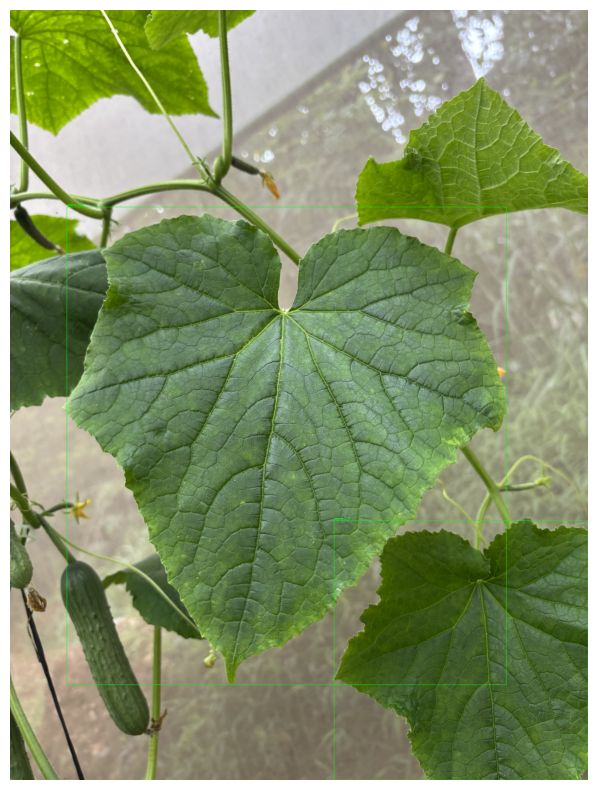

✅ Detections shown (threshold=0.5)
Detections count: 2


In [22]:
from google.colab import files
uploaded = files.upload()

img_path = list(uploaded.keys())[0]
print("Uploaded image:", img_path)
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt = torch.load("/content/fasterrcnn_roboflow.pth", map_location=device)
num_classes = ckpt["num_classes"]
class_names = ckpt["class_names"]

# build model structure
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# load weights
model.load_state_dict(ckpt["model_state"])
model.to(device)
model.eval()

print("✅ Model loaded")
print("Classes:", class_names)
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from PIL import Image

def predict_and_draw(img_path, score_thr=0.5):
    # read image (OpenCV BGR)
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        raise ValueError("Could not read the image. Check the path.")

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # to tensor
    img_pil = Image.fromarray(img_rgb)
    img_tensor = F.to_tensor(img_pil).to(device)

    # inference
    with torch.no_grad():
        pred = model([img_tensor])[0]

    boxes = pred["boxes"].cpu().numpy()
    scores = pred["scores"].cpu().numpy()
    labels = pred["labels"].cpu().numpy()

    keep = scores >= score_thr
    boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

    # draw on original image
    drawn = img_bgr.copy()

    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box.astype(int)

        # label index starts from 1 (0 is background)
        class_name = class_names[label - 1] if (label - 1) < len(class_names) else str(label)

        cv2.rectangle(drawn, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(
            drawn,
            f"{class_name} {score:.2f}",
            (x1, max(20, y1 - 10)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 255, 0),
            2
        )

    # show result
    drawn_rgb = cv2.cvtColor(drawn, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,10))
    plt.imshow(drawn_rgb)
    plt.axis("off")
    plt.show()

    print(f"✅ Detections shown (threshold={score_thr})")
    print("Detections count:", len(boxes))

predict_and_draw(img_path, score_thr=0.5)


In [23]:
import torch
from tqdm import tqdm
from pycocotools.cocoeval import COCOeval
import numpy as np

@torch.no_grad()
def evaluate_map(model, val_ds, val_loader, device, score_thr=0.05):
    model.eval()

    coco_gt = val_ds.coco  # ground truth COCO object
    inv_map = {v: k for k, v in val_ds.cat_id_to_contig.items()}  # contig label -> original coco category_id

    results = []

    for images, targets in tqdm(val_loader):
        images = [img.to(device) for img in images]
        outputs = model(images)

        for out, t in zip(outputs, targets):
            image_id = int(t["image_id"].item())

            boxes = out["boxes"].detach().cpu().numpy()
            scores = out["scores"].detach().cpu().numpy()
            labels = out["labels"].detach().cpu().numpy()

            keep = scores >= score_thr
            boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

            for box, score, label in zip(boxes, scores, labels):
                x1, y1, x2, y2 = box
                w, h = float(x2 - x1), float(y2 - y1)

                results.append({
                    "image_id": image_id,
                    "category_id": int(inv_map[int(label)]),   # back to COCO category id
                    "bbox": [float(x1), float(y1), w, h],     # COCO expects [x,y,w,h]
                    "score": float(score)
                })

    if len(results) == 0:
        print("No predictions found. Lower score_thr (e.g., 0.01).")
        return None

    coco_dt = coco_gt.loadRes(results)

    coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    stats = coco_eval.stats
    print("\n✅ Main 'accuracy-like' numbers:")
    print(f"mAP@[0.5:0.95] = {stats[0]*100:.2f}%")
    print(f"mAP@0.50       = {stats[1]*100:.2f}%")
    print(f"mAP@0.75       = {stats[2]*100:.2f}%")

    return stats

# Run evaluation
stats = evaluate_map(model, val_ds, val_loader, device, score_thr=0.05)


100%|██████████| 201/201 [00:18<00:00, 11.05it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.810
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.905
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.814
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.866
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.868
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.868
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1